<h1 style="text-align: center;"> After applying of post-processing we need to obtain the optimal MF(median filter) size and threshold. This file contains functions related to this task. 
    <h2 style="text-align: center;"> <b>"Impact of Pre- and Post-Processing Steps for Supervised Classification of Colorectal Cancer in Hyperspectral Images" </b> </h2>
</h1> 
<h3>
    Paper: <a href='https://www.mdpi.com/2233040'>https://www.mdpi.com/2233040 </a> <br>
    Documentation: <a href='https://git.iccas.de/MaktabiM/hsi-experiments/-/wikis/Post-processing'>https://git.iccas.de/MaktabiM/hsi-experiments/-/wikis/Post-processing </a> <br> <br>
    
    The notebook is divided into sections for simplicity. <br>
    The most important section is Part 1. Others are rather for archive, need refactoring or inspiration.
</h3>

<h1 style="text-align: center;"> Part 1. Getting of the optimal parameters (MF size, threshold) and corresponding improvements for models - Section 2.4 in paper </h1>

In [1]:
import csv
import numpy as np
#import ipyvolume as ipv
from scipy.interpolate import griddata
import os
import pandas as pd

In [2]:
import sys
sys.path.insert(0, '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/evaluation')

from optimal_parameters import OptimalThreshold
from metrics_csvreader import MetricsCsvReader, MetricsCsvReaderComparisonFiles

2023-07-17 21:55:25.225521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class OptimalPostprocessingParameters:   
    def __init__(self, home, model, optimal_threshold=None):
        folder = os.path.join(home, model)
        
        #old, for paper models: self.read_metrics(os.path.join(folder, 'compare_all_thresholds_filtered_AP.csv'))
        self.read_metrics(os.path.join(folder, 'compare_all_thresholds_postprocessed_AP.csv'))
        
        sensitivity_baseline, specificity_baseline = self.get_baseline_sensitivity_and_specificity(folder, optimal_threshold=optimal_threshold)  #paper, Section 2.3.5
        print('Baseline sensitivity and specificity:', sensitivity_baseline, specificity_baseline)
        self.sensitivity_baseline = sensitivity_baseline
        self.specificity_baseline = specificity_baseline
        
    
    def read_metrics(self, metrics_csvfile):
        metrics = MetricsCsvReaderComparisonFiles().read_metrics(metrics_csvfile, names=['Threshold', 'median', 'Sensitivity', 'Specificity'])
        
        self.thresholds = np.array(metrics['Threshold'])
        self.MF_sizes = np.array(metrics['median'])
        self.sensitivities = np.array(metrics['Sensitivity'])
        self.specificities = np.array(metrics['Specificity'])
        
        print('All tested thresholds:', np.unique(self.thresholds))
        print('All tested MF_sizes:', np.unique(self.MF_sizes))
        
    
    def get_baseline_sensitivity_and_specificity(self, folder, optimal_threshold=None):
        optimal = OptimalThreshold(folder, prints=False)
        
        if optimal_threshold is None:
            optimal_threshold, sensitivity_baseline, specificity_baseline, _, _ = optimal.find_optimal_threshold_in_checkpoint(folder)
            print("Optimal threshold", optimal_threshold)
        else:
            print(f'Given threshold: {optimal_threshold}')
            sensitivity_baseline, specificity_baseline, _, _ = optimal.get_values_by_threshold(folder, optimal_threshold)
        
        return sensitivity_baseline, specificity_baseline
    
    def get_optimal_post_processing_parameters(self):  # paper, Algorithm 1 (Section 2.4.4)
        def print_best_results(prints=False):
            improvements = self.get_improvements()     # paper, Algorithm 1, Equation (5)
            maximal_improvement = np.argmax(improvements)   # paper, Algorithm 1, Equation (6)
            print(f'======= Optimal post-processing parameters and improvements =======')
            print(f'Optimal threshold: {self.thresholds_condition[maximal_improvement]}')
            print(f'Optimal median filter(MF) size: {self.MF_sizes_condition[maximal_improvement]}')
            print(f'Sensitivity after postprocessing: {self.sensitivities_condition[maximal_improvement]}')
            print(f'Specificity after post-processing: {self.specificities_condition[maximal_improvement]}')
            print(f'Improvement total: {improvements[maximal_improvement]}')
            print(f'Improvement for sensitivity: {self.sensitivities_condition[maximal_improvement] - self.sensitivity_baseline}')
            print(f'Improvement for specificity: {self.specificities_condition[maximal_improvement] - self.specificity_baseline}')
            
            if prints:
                for se, sp, th, med, impr in zip(self.sensitivities_condition, 
                                              self.specificities_condition, 
                                              self.thresholds_condition, 
                                              self.MF_sizes_condition, 
                                              improvements):
                    print(se, sp, th, med, impr, se-self.sensitivity_baseline, sp-self.specificity_baseline)
                    
        condition = self.get_condition()  # paper, Algorithm 1 (Section 2.4.4), in fact Equations (3) and (4)
        self.sensitivities_condition = self.sensitivities[condition] 
        self.specificities_condition = self.specificities[condition] 
        self.thresholds_condition = self.thresholds[condition]
        self.MF_sizes_condition = self.MF_sizes[condition]
        
        print_best_results()
    
    def get_condition(self):  
        return (self.sensitivities > self.sensitivity_baseline) & (self.specificities > self.specificity_baseline)
    
    def get_improvements(self):
        improvements = (self.sensitivities_condition - self.sensitivity_baseline) + (self.specificities_condition - self.specificity_baseline)   
        return improvements
        
    
    def plot_3d(self, path):  # only for binary classification, so far works only locally
        #X_o, Y_o, Z_o = self.get_X_Y_Z_baseline(np.unique(MF_sizes))
        self.mean = np.mean(self.sensitivity_baseline + self.specificity_baseline)

        xv = np.linspace(min(self.thresholds), max(self.thresholds), 100);
        yv = np.linspace(min(self.MF_sizes), max(self.MF_sizes), 100);

        [X,Y] = np.meshgrid(xv, yv)

        Z_sensitivities = griddata((self.thresholds, self.MF_sizes), self.sensitivities, (X,Y), method='linear')
        Z_specificities = griddata((self.thresholds, self.MF_sizes), self.specificities, (X,Y), method='linear')
        Z_baseline = griddata((self.thresholds, self.MF_sizes), 
                              self.mean * np.ones(self.sensitivities.shape[0]), 
                              (X,Y), method='linear')

        ipv.xlim(xmin=np.min(X), xmax=np.max(X))
        ipv.ylim(ymin=np.min(Y), ymax=np.max(Y))
        ipv.zlim(zmin=min(np.min(Z_specificities), np.min(Z_sensitivities)), 
                 zmax=max(np.max(Z_specificities), np.max(Z_sensitivities)))
        ipv.plot_surface(X, Y, Z_specificities, color='blue')
        ipv.plot_surface(X, Y, Z_sensitivities)
        ipv.plot_surface(X, Y, Z_baseline, color='green')
        #ipv.show()
        ipv.clear()
    
    '''def get_X_Y_Z_baseline(self, medians):   

        X_raw = self.best_threshold * np.ones(medians.shape[0])
        Y_raw = medians
        Z_raw = self.mean * np.ones(medians.shape[0])
        #Z_raw = [mean] * np.ones(medians.shape[0])

        return X_raw, Y_raw, Z_raw'''

class OptimalPostprocessingParametersMulticlass(OptimalPostprocessingParameters):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def get_baseline_sensitivity_and_specificity(self, folder, optimal_threshold=None):
        metrics = MetricsCsvReaderComparisonFiles().read_metrics(os.path.join(folder, 'compare_all_thresholds.csv'), names=['Sensitivity', 'Specificity'])
        return metrics['Sensitivity'][0], metrics['Specificity'][0]
    
    def get_condition(self):  
        return np.ones(self.sensitivities.shape[0]).astype(bool)  # for multiclass we skip condition (return all True), just take pure improvements, because usually nevertheless for some class 
        #old:
        #condition = np.greater_equal(self.sensitivities, self.sensitivity_baseline) & np.greater_equal(self.specificities, self.specificity_baseline)
        #return np.prod(condition, axis=1).astype(bool)
    
    def get_improvements(self):
        improvements = np.sum((self.sensitivities_condition - self.sensitivity_baseline) + (self.specificities_condition - self.specificity_baseline), axis=1)   
    
        return improvements
        

home = "/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/test/"
model = "Colon_MedianFilter/cp-0000"
#model = 'CV_3d_inception/cp-l2_norm_0036/'
#model = 'Esophagus_MedFilter/cp-0000'    # use OptimalPostprocessingParametersMulticlass for it
        
optimal = OptimalPostprocessingParameters(home, model)
optimal.get_optimal_post_processing_parameters()            


All tested thresholds: [0.0001 0.0003 0.0006 0.0008 0.001 ]
All tested MF_sizes: [ 5 11 15 21 25 31 41 51 61]
~~~~~~~~~~~~~~~~You need to add new thresholds starts from /home/sc.uni-leipzig.de/mi186veva/hsi-experiments/test/Colon_MedianFilter/cp-0000~~~~~~~~~~~~~~
Optimal threshold [1.e-04]
Baseline sensitivity and specificity: [0.87873036] [0.78824425]
======= Optimal post-processing parameters and improvements =======
Optimal threshold: 0.0001
Optimal median filter(MF) size: 21
Sensitivity after postprocessing: 0.8806911131251793
Specificity after post-processing: 0.8231029794591757
Improvement total: 0.03681948845456373
Improvement for sensitivity: [0.00196075]
Improvement for specificity: [0.0348587]


In [4]:
# Calculating optimal post-processing parameters for paper models
# Don't forget to change filename to old one in __init__ of OptimalPostprocessingParameters
#home = 'C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\'
home = '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/test/'

for model, threshold in zip(['CV_3d_inception/cp-l2_norm_0036/',
            'CV_3d_inception_exclude1_all/cp-svn_T_0016/',
            'CV_3d_inception_svn_every_third/cp-svn_T_0018/',
            'CV_3d_svn_every_third/cp-svn_T_0016/',
            'CV_3d_sample_weights_every_third/cp-svn_T_0018/',
            'CV_3d_every_third/cp-l2_norm_0016/',
            'CV_3d_inception_exclude1_every_third/cp-svn_T_0016/',
            ],
                [0.2111,
                 0.0189, 
                 0.0456,
                 0.0367, 
                 0.45,
                 0.1556, 
                 0.0456
            ]):
    print(model)
    optimal = OptimalPostprocessingParameters(home, model, optimal_threshold=threshold)
    optimal.get_optimal_post_processing_parameters()
    print('-------------------------------------------------------------------------------')

CV_3d_inception/cp-l2_norm_0036/


FileNotFoundError: [Errno 2] No such file or directory: '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/test/CV_3d_inception/cp-l2_norm_0036/compare_all_thresholds_postprocessed_AP.csv'

In [1]:
# With all these commands I tried to turn on 3d plots on cluster, but nothing worked
# 3d plots work only locally  

#!pip install --user --upgrade ipywidgets
#%matplotlib widget
#!jupyter  labextension install jupyter-matplotlib
#!pip install --user --upgrade ipyvolume==0.6.0a6
#!pip install --user --upgrade bqplot
#!jupyter labextension install --user bqplot

<h1 style="text-align: center;">Part 2. Research about automatic ranges detection (ranges for MF sizes and thresholds) </h1> 
is not fihished and probably doesn't work, because Plot3d class was created  

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sens_v = np.linspace(min(sens), max(sens), 100)
spec_v = np.linspace(min(spec), max(spec), 100)

[X,Y] = np.meshgrid(xv, sens_v)
    
Z_sens = griddata((thresholds,medians),sens,(X,Y), method='linear')
Z_spec = griddata((thresholds,medians),spec,(X,Y), method='linear')

[[-0.03934341 -0.03771663 -0.03608985 ...         nan         nan
          nan]
 [-0.03929206 -0.03778838 -0.03616161 ...         nan         nan
          nan]
 [-0.03924072 -0.03782213 -0.03623336 ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...  0.03824596  0.03886385
   0.03946124]
 [        nan         nan         nan ...  0.03826864  0.03890581
   0.03951344]
 [        nan         nan         nan ...  0.03829132  0.03892848
   0.03956565]]


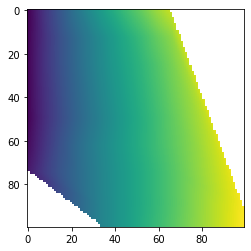

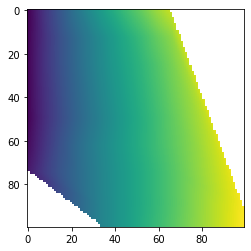


[-1.  1. nan ... nan nan nan]


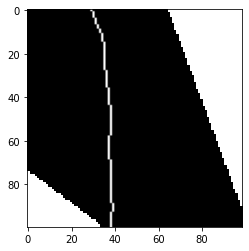

In [46]:
#show intersection between surfaces of sens and spec
# -> it will (probably) help us to automaticly understand what ranges to try
# probably this part doesn't work, becausse previous two cells were updated
# -> probably we need to hide this part inside Plot3d class

Z_diff = Z_spec - Z_sens

ipv.plot_surface(X, Y, Z_diff, color='yellow')
ipv.show()
ipv.clear()


print(Z_diff)

plt.imshow(Z_diff)
plt.show()

plt.imshow(Z_diff)
plt.show()

print()

plt.imshow(np.sign(Z_diff), cmap='gray')
plt.imshow(np.diff(np.sign(Z_diff)), cmap='gray')

print(np.unique(np.sign(Z_diff)))

<h1 style="text-align: center;">(needs refactoring) Part 3. Getting of all improvements for one model that fits condition that new (with post-processing) sens and spec are higher then old sens and spec (before post-processing) </h1>
probably doesn't work, because Plot3d class was created (we need to hide it inside it)

In [2]:
from IPython.display import display
import pandas as pd

In [1]:
#print best improvements for one model

condition = (sens > means[0]) & (spec > means[0])
sens_more = sens[condition] 
spec_more = spec[condition] 
thresholds_more = thresholds[condition]
medians_more = medians[condition]

improvement_ = sens_more + spec_more - (2 * means[0])
improvement_i = np.argmax(improvement_)
print('With best improvement', sens_more[improvement_i], spec_more[improvement_i], thresholds_more[improvement_i], medians_more[improvement_i], improvement_[improvement_i])

stacked_values = np.array([medians_more, sens_more, spec_more, thresholds_more, improvement_ * 100]).T
stacked_values = stacked_values[stacked_values[:, -1][::-1].argsort()]

df = pd.DataFrame(stacked_values)
df.columns =['Median', 'Sensitivity', 'Specificity', 'Threshold', 'Improvement %']
  
# displaying the DataFrame
display(df[:20])


for se, sp, th, med, s in zip(sens_more, spec_more, thresholds_more, medians_more, improvement_):
    print(se, sp, th, med, s)#, se-means[0], sp-means[0])
    


NameError: name 'sens' is not defined

In [17]:
#print best thresholds with harmony

print(sens.shape)

display_array = []

for m in np.unique(medians):
    condition = medians == m
    sens_c = sens[condition] 
    spec_c = spec[condition] 
    thresholds_c = thresholds[condition]
    medians_c = medians[condition]
    improvement = sens_c + spec_c - (2 * means[0])
    
    diff = np.abs(sens_c - spec_c)
    diff_i = np.argmin(diff)
    #print(#'Best threshold with harmony', 
    display_array.append([medians_c[diff_i], sens_c[diff_i], 
          spec_c[diff_i], thresholds_c[diff_i], improvement[diff_i] * 100])
    
df = pd.DataFrame(display_array)
df.columns =['Median', 'Sensitivity', 'Specificity', 'Threshold', 'Improvement %']
  
# displaying the DataFrame
display(df)


(101,)


,Median,Sensitivity,Specificity,Threshold,Improvement %
0,5.0,0.902511,0.902160,0.1994,1.922187
1,10.0,0.910085,0.911704,0.2228,3.633996
2,15.0,0.914627,0.915461,0.2228,4.463913
3,25.0,0.920533,0.918951,0.2228,5.403437
4,30.0,0.920763,0.920242,0.2228,5.555525
5,35.0,0.922563,0.921311,0.2228,5.842438
6,41.0,0.923101,0.924043,0.2346,6.169538
7,45.0,0.923698,0.924657,0.2346,6.290577
8,51.0,0.926328,0.922412,0.2111,6.329016
9,55.0,0.925998,0.923101,0.2111,6.364939


<h1 style="text-align: center;">Part 5. Old getting of improvements (just archive) </h1>
to make working fast old parts

In [ ]:
import bqplot.scales
#%matplotlib widget
#with open('test/CV_3d_inception/cp-l2_norm_0036/compare_all_thresholds_filtered.csv', newline='') as csvfile:

#validator = Validator('test/CV_3d_inception')
#best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('test/CV_3d_inception/cp-l2_norm_0036')
#validator = Validator('test/Colon_MedianFilter')
#best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('test/Colon_MedianFilter/cp-0000')
validator = Validator('C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\CV_3d_inception')
best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\CV_3d_inception\\cp-0000')


print(best_threshold)
print(means)
print(best_sens, best_spec)
if type(means) != list:
    means = [means]

def get_X_Y_Z_original(medians):

    X_raw = best_threshold * np.ones(medians.shape[0])
    Y_raw = medians
    Z_raw = means[0] * np.ones(medians.shape[0])
    #Z_raw = [means] * np.ones(medians.shape[0])
    
    return X_raw, Y_raw, Z_raw

with open('C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\CV_3d_inception\\cp-0000\\compare_all_thresholds_filtered.csv', newline='') as csvfile:
    report_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    #print(next(report_reader))
    next(report_reader)
    data = []
    for row in report_reader:
        data.append(row)
        
    data = np.array(data)
    print(data[:10])
    
    thresholds = data[:, 2].astype(float)
    medians = data[:, -1].astype(float)
    sens = data[:, 3].astype(float)
    spec = data[:, 4].astype(float)
    
    #print('unique medians', np.unique(medians))
    
    X_o, Y_o, Z_o = get_X_Y_Z_original(np.unique(medians))
    #print(X_o, Y_o, Z_o)
    
    xv = np.linspace(min(thresholds), max(thresholds), 100);
    yv = np.linspace(min(medians), max(medians), 100);
    
    [X,Y] = np.meshgrid(xv, yv)
    
    #print('---------------X------------------')
    #print(X)
    #print('---------------Y------------------')
    #print(Y)
    Z_sens = griddata((thresholds,medians),sens,(X,Y), method='linear')
    Z_spec = griddata((thresholds,medians),spec,(X,Y), method='linear')
    Z_baseline = griddata((thresholds,medians),means[0] * np.ones(sens.shape[0]),(X,Y), method='linear')
    print('---------------Z sens------------------')
    print(Z_sens)
    
    #X, Y = np.meshgrid(thresholds, medians)
    #print(X.shape)
    #print(sens)
    #sens, spec = np.meshgrid(sens, spec)
    #spec, _ = np.meshgrid(spec, spec)
    #print(sens)
    
    
    #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # surf = ax.plot_surface(X, Y, Z_spec, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    #ipv.scatter(thresholds, medians, sens)
    
    '''scales = {
        'z': bqplot.scales.LinearScale(min=0, max=1),
    }'''
    print(np.max(X), np.min(X), np.max(Y), np.min(Y), np.max(Z_spec), np.min(Z_spec), np.max(Z_sens), np.min(Z_sens))
    
    
    
    ipv.xlim(xmin=np.min(X), xmax=np.max(X))
    ipv.ylim(ymin=np.min(Y), ymax=np.max(Y))
    ipv.zlim(zmin=min(np.min(Z_spec), np.min(Z_sens)), zmax=max(np.max(Z_spec), np.max(Z_sens)))
    #ipv.plot(X_o, Y_o, Z_o, color='green')
    ipv.plot_surface(X, Y, Z_spec, color='blue')
    ipv.plot_surface(X, Y, Z_sens)
    ipv.plot_surface(X, Y, Z_baseline, color='green')    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #ipv.plot_surface(X, Y, Z_spec - Z_sens, color='yellow')
    ipv.show()
    #ipv.save('1.html')
    ipv.clear()

<h1 style="text-align: center;">Some experiments </h1> 


In [ ]:
#probably I tried to make 3d plots work on cluster

#!/usr/bin/python3

import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy
from numpy.random import randn
from scipy import array, newaxis


# ======
## data:

DATA = array([
    [-0.807237702464, 0.904373229492, 111.428744443],
    [-0.802470821517, 0.832159465335, 98.572957317],
    [-0.801052795982, 0.744231916692, 86.485869328],
    [-0.802505546206, 0.642324228721, 75.279804677],
    [-0.804158144115, 0.52882485495, 65.112895758],
    [-0.806418040943, 0.405733109371, 56.1627277595],
    [-0.808515314192, 0.275100227689, 48.508994388],
    [-0.809879521648, 0.139140394575, 42.1027499025],
    [-0.810645106092, -7.48279012695e-06, 36.8668106345],
    [-0.810676720161, -0.139773175337, 32.714580273],
    [-0.811308686707, -0.277276065449, 29.5977405865],
    [-0.812331692291, -0.40975978382, 27.6210856615],
    [-0.816075037319, -0.535615685086, 27.2420699235],
    [-0.823691366944, -0.654350489595, 29.1823292975],
    [-0.836688691603, -0.765630198427, 34.2275056775],
    [-0.854984518665, -0.86845932028, 43.029581434],
    [-0.879261949054, -0.961799684483, 55.9594146815],
    [-0.740499820944, 0.901631050387, 97.0261463995],
    [-0.735011699497, 0.82881933383, 84.971061395],
    [-0.733021568161, 0.740454485354, 73.733621269],
    [-0.732821755233, 0.638770044767, 63.3815970475],
    [-0.733876941678, 0.525818698874, 54.0655910105],
    [-0.735055978521, 0.403303715698, 45.90859502],
    [-0.736448900325, 0.273425879041, 38.935709456],
    [-0.737556181137, 0.13826504904, 33.096106049],
    [-0.738278724065, -9.73058423274e-06, 28.359664343],
    [-0.738507612286, -0.138781586244, 24.627237837],
    [-0.738539663773, -0.275090412979, 21.857410904],
    [-0.739099040189, -0.406068448513, 20.1110519655],
    [-0.741152200369, -0.529726022182, 19.7019157715],
])

Xs = DATA[:,0]
Ys = DATA[:,1]
Zs = DATA[:,2]


# ======
## plot:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.show() # or: